# **1. Install packages**

In [102]:
%%capture
pip install segmentation-models-pytorch

# **2. Import libraries**

In [103]:
# Data handling
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2

# Torch
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import segmentation_models_pytorch as smp
from torchinfo import summary

# os
import os

# Path
from pathlib import Path

# tqdm
from tqdm.auto import tqdm

# warnings
import warnings
warnings.filterwarnings("ignore")

# **3. Load data**

In [104]:
# We define a function to create a list of the paths of the images and masks.
def image_mask_path(image_path:str, mask_path:str):
    IMAGE_PATH = Path(image_path)
    IMAGE_PATH_LIST = sorted(list(IMAGE_PATH.glob("*.png")))

    MASK_PATH = Path(mask_path)
    MASK_PATH_LIST = sorted(list(MASK_PATH.glob("*.png")))
    
    return IMAGE_PATH_LIST, MASK_PATH_LIST

In [105]:
image_path_train = "/home/training/NCU/DL/FinalProject/PreprocessedNoisyDataset/BCSS/train"
mask_path_train = "/home/training/NCU/DL/FinalProject/OriginalDataset/BCSS/train_mask"

IMAGE_PATH_LIST_TRAIN, MASK_PATH_LIST_TRAIN = image_mask_path(image_path_train, 
                                                              mask_path_train)

print(f'Total Images Train: {len(IMAGE_PATH_LIST_TRAIN)}')
print(f'Total Masks Train: {len(MASK_PATH_LIST_TRAIN)}')

Total Images Train: 30760
Total Masks Train: 30760


In [106]:
image_path_val = "/home/training/NCU/DL/FinalProject/PreprocessedNoisyDataset/BCSS/val"
mask_path_val = "/home/training/NCU/DL/FinalProject/OriginalDataset/BCSS/val_mask"

IMAGE_PATH_LIST_VAL, MASK_PATH_LIST_VAL = image_mask_path(image_path_val, 
                                                          mask_path_val)

print(f'Total Images Val: {len(IMAGE_PATH_LIST_VAL)}')
print(f'Total Masks Val: {len(MASK_PATH_LIST_VAL)}')

Total Images Val: 5429
Total Masks Val: 5429


**For processing the low-contrast image mask :**

In [109]:
VALUES_UNIQUE_TRAIN = []

for i in MASK_PATH_LIST_TRAIN:
    sample = cv2.imread(str(i), cv2.IMREAD_GRAYSCALE)
    uniques = np.unique(sample)
    VALUES_UNIQUE_TRAIN.append(uniques)
    
FINAL_VALUES_UNIQUE_TRAIN = np.concatenate(VALUES_UNIQUE_TRAIN)
print("Unique values Train:\n")
print(np.unique(FINAL_VALUES_UNIQUE_TRAIN))

Unique values Train:

[0 1 2]


In [110]:
VALUES_UNIQUE_VAL = []

for i in MASK_PATH_LIST_VAL:
    sample = cv2.imread(str(i), cv2.IMREAD_GRAYSCALE)
    uniques = np.unique(sample)
    VALUES_UNIQUE_VAL.append(uniques)
    
FINAL_VALUES_UNIQUE_VAL = np.concatenate(VALUES_UNIQUE_VAL)
print("Unique values Validation:\n")
print(np.unique(FINAL_VALUES_UNIQUE_VAL))

Unique values Validation:

[0 1 2]


In [111]:
NUM_CLASSES = 3

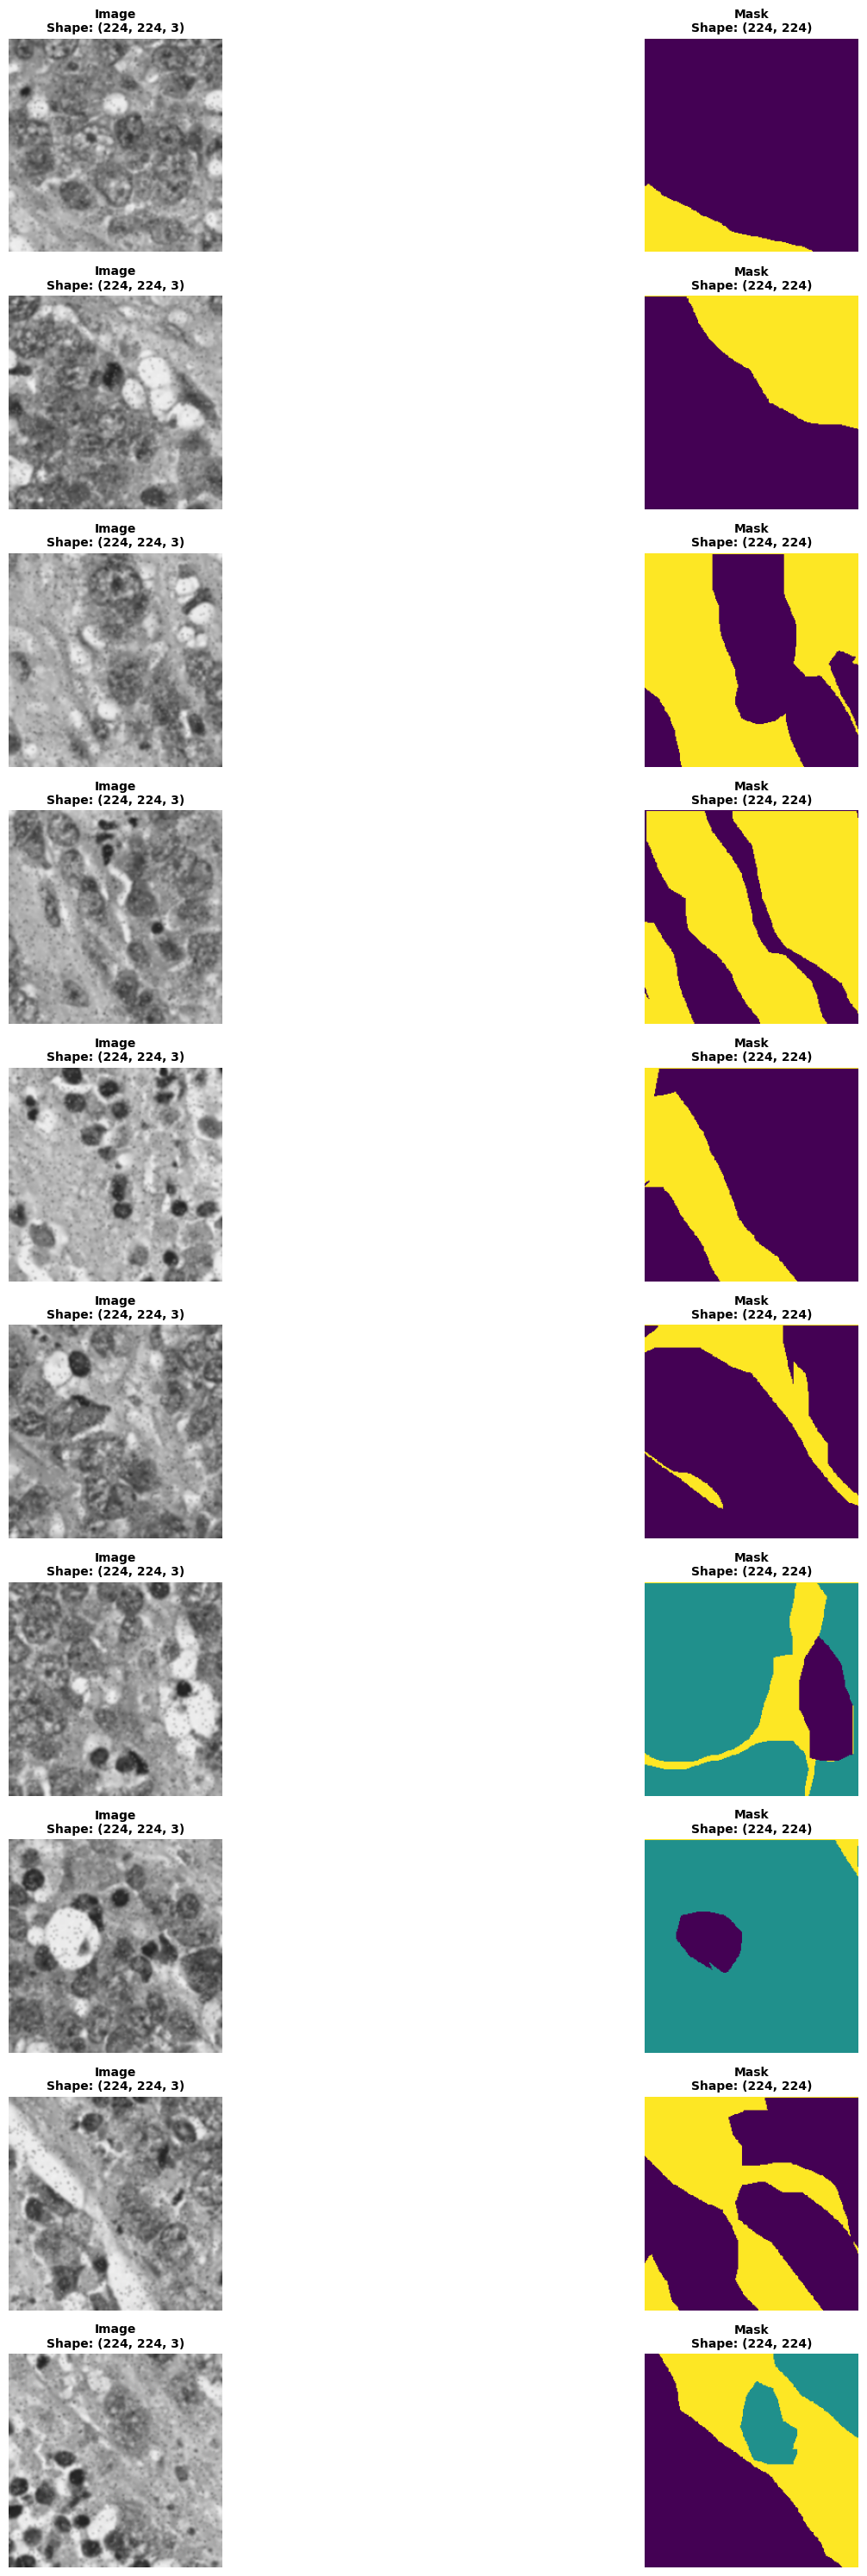

In [112]:
# We see some images and next to them their respective mask.
fig, ax = plt.subplots(nrows = 10, ncols = 2, figsize = (20,30))

for i,(img_path, mask_path) in enumerate(zip(IMAGE_PATH_LIST_TRAIN, MASK_PATH_LIST_TRAIN)):
    
    if i>9:
        break
        
    img_bgr = cv2.imread(str(img_path))
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    ax[i,0].imshow(img_rgb)
    ax[i,0].axis('off')
    ax[i,0].set_title(f"Image\nShape: {img_rgb.shape}", fontsize = 10, fontweight = "bold", color = "black")

    mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
    ax[i,1].imshow(mask)
    ax[i,1].axis('off')
    ax[i,1].set_title(f"Mask\nShape: {mask.shape}", fontsize = 10, fontweight = "bold", color = "black")

fig.tight_layout()
fig.show()

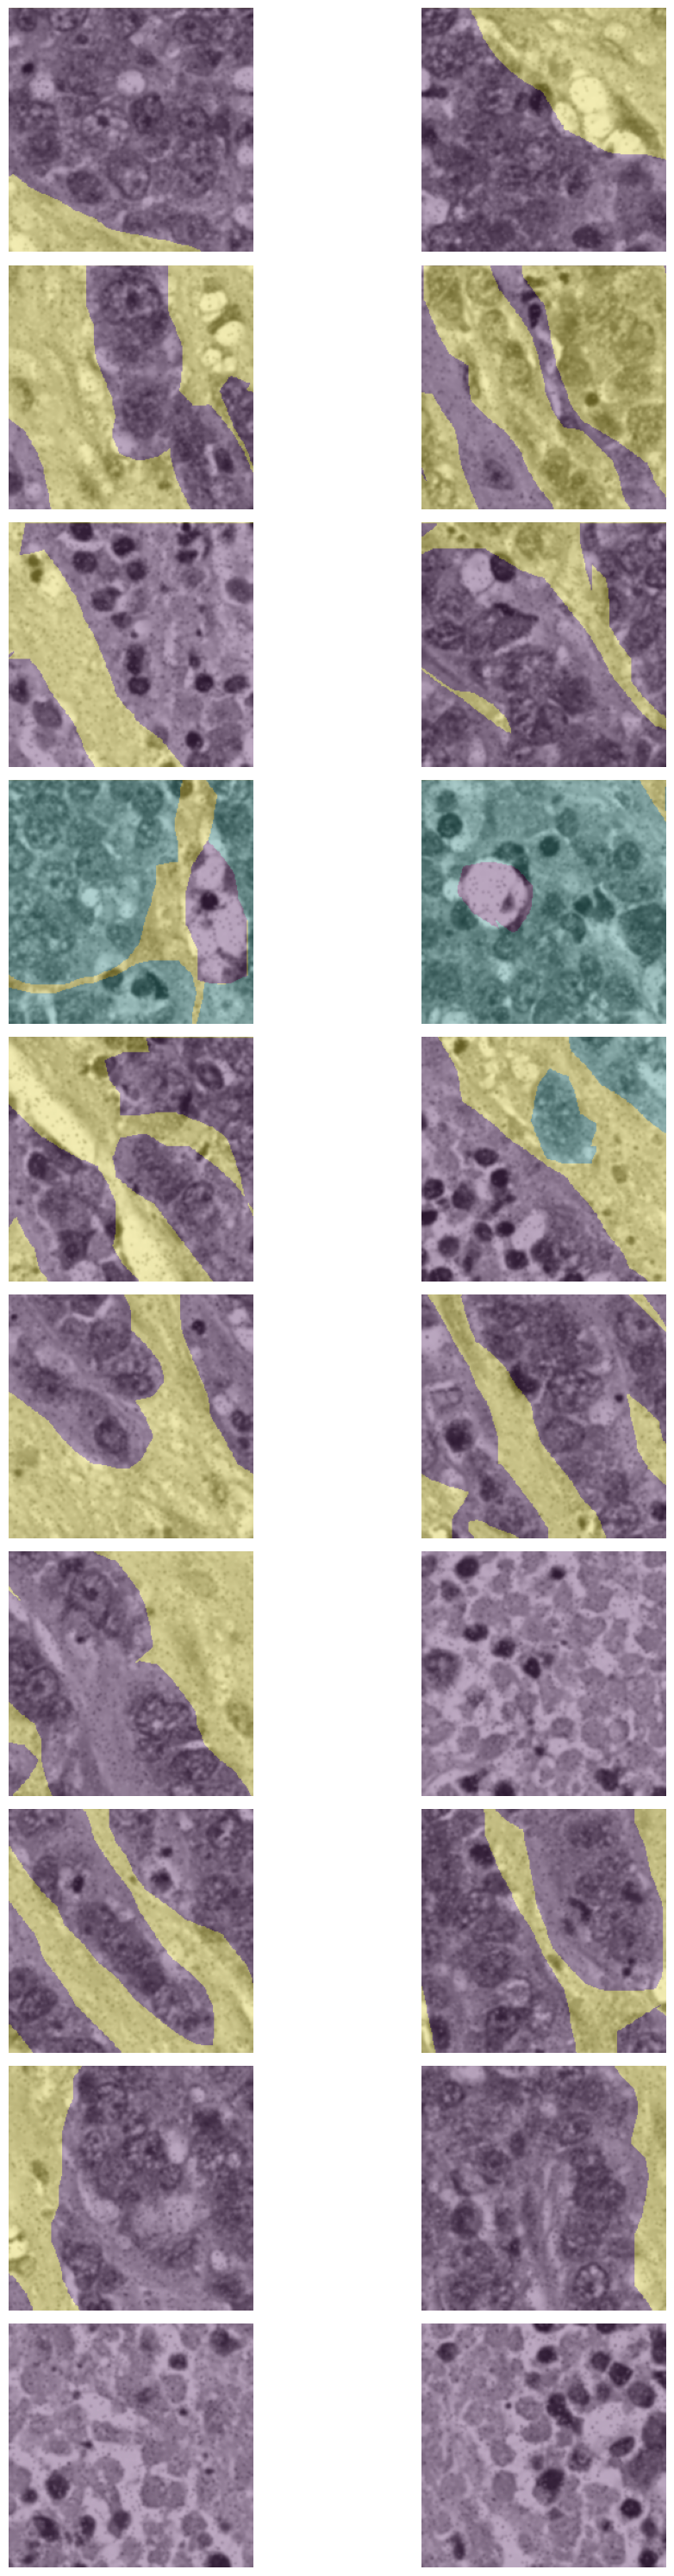

In [113]:
# We visualize some images but with the mask superimposed.
fig, ax = plt.subplots(nrows = 10, ncols = 2, figsize = (12,30))
ax = ax.flat

for i,(img_path, mask_path) in enumerate(zip(IMAGE_PATH_LIST_TRAIN, MASK_PATH_LIST_TRAIN)):
    
    if i>19:
        break
        
    img_bgr = cv2.imread(str(img_path))
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    ax[i].imshow(img_rgb)
    ax[i].axis('off')
    

    mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
    ax[i].imshow(mask, alpha = 0.30)
    ax[i].axis('off')
    

fig.tight_layout()
fig.show()

# **4. Preprocessing**

**We will create dataframes for both data sets.**

In [114]:
data_train = pd.DataFrame({'Image':IMAGE_PATH_LIST_TRAIN, 
                           'Mask':MASK_PATH_LIST_TRAIN})

data_val = pd.DataFrame({'Image':IMAGE_PATH_LIST_VAL, 
                         'Mask':MASK_PATH_LIST_VAL})

**Now we are going to find out what transformations were applied to the images when the model was pre-trained in order to replicate it in our images.**

In [115]:
preprocess_input = smp.encoders.get_preprocessing_fn(encoder_name = "resnet50", 
                                        pretrained = "imagenet")
preprocess_input

functools.partial(<function preprocess_input at 0x7faf0939a7a0>, input_space='RGB', input_range=[0, 1], mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

**We are going to replicate this same thing.**

In [116]:
RESIZE = (224, 224)
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

image_transforms = transforms.Compose([transforms.Resize(RESIZE),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean = MEAN, std = STD)])

mask_transforms = transforms.Compose([transforms.Resize(RESIZE), 
                                      transforms.PILToTensor()])

**We define our Dataset with all the transformations to perform.**

- **Dataset**

In [117]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

# Define augmentation pipeline
train_transforms = A.Compose([
    A.HorizontalFlip(p=0.5),  # Flip horizontally with 50% probability
    A.RandomRotate90(p=0.5),  # Random 90-degree rotations
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),  # Affine transforms
    A.GaussianBlur(blur_limit=(3, 7), p=0.3),  # Blur
    A.RandomBrightnessContrast(p=0.5),  # Adjust brightness and contrast
    A.ElasticTransform(p=0.5),
    A.Normalize(mean=MEAN, std=STD),  # Normalize
    ToTensorV2(),  # Convert to PyTorch tensors
])

val_transforms = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=MEAN, std=STD),
    ToTensorV2(),
])


In [118]:
class OldCustomImageMaskDataset(Dataset):
    def __init__(self, data:pd.DataFrame, image_transforms, mask_transforms):
        self.data = data
        self.image_transforms = image_transforms
        self.mask_transforms = mask_transforms
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image_path = self.data.iloc[idx, 0]
        image = Image.open(image_path).convert("RGB")
        image = self.image_transforms(image)
        
        mask_path = self.data.iloc[idx, 1]
        mask = Image.open(mask_path)
        mask = self.mask_transforms(mask)
        
        return image, mask

In [119]:
class CustomImageMaskDataset(Dataset):
    def __init__(self, data: pd.DataFrame, transforms=None):
        self.data = data
        self.transforms = transforms
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image_path = self.data.iloc[idx, 0]
        mask_path = self.data.iloc[idx, 1]
        
        # Load the image and mask
        image = cv2.imread(image_path)  # Read image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Read mask as grayscale
        
        # Apply augmentations
        if self.transforms:
            augmented = self.transforms(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        
        return image, mask


In [121]:
train_dataset = OldCustomImageMaskDataset(data_train, image_transforms, 
                                       mask_transforms)
    
val_dataset = OldCustomImageMaskDataset(data_val, image_transforms, 
                                     mask_transforms)

- **DataLoader**

In [122]:
BATCH_SIZE = 64
NUM_WORKERS = os.cpu_count()

print("Num Workers : ", NUM_WORKERS)

NUM_WORKERS = 1
train_dataloader = DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE, 
                              shuffle = True)

val_dataloader = DataLoader(dataset = val_dataset, batch_size = BATCH_SIZE, 
                            shuffle = False)

Num Workers :  20


In [124]:
torch.cuda.empty_cache()

In [125]:
# We visualize the dimensions of a batch.
batch_images, batch_masks = next(iter(train_dataloader))

batch_images.shape, batch_masks.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64, 1, 224, 224]))

# **5. Model**

In [126]:
# CUDA
if torch.cuda.is_available():
    print("CUDA is available!")
    print(f"Device name: {torch.cuda.get_device_name(0)}")
    print(f"Number of available GPUs: {torch.cuda.device_count()}")
else:
    print("CUDA is not available. Running on CPU.")

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

CUDA is available!
Device name: NVIDIA GeForce RTX 3080 Ti
Number of available GPUs: 1


In [127]:
# Define model
model = smp.Unet(encoder_name="resnet50", classes=NUM_CLASSES, in_channels=3)
model.segmentation_head = nn.Sequential(
    model.segmentation_head,
    nn.Dropout2d(p=0.5)
)

In [128]:
# Now Let's visualize the architecture of our model.
summary(model = model, 
        input_size = [64, 3, 224, 224], 
        col_width = 15, 
        col_names = ['input_size', 'output_size', 'num_params', 'trainable'], 
        row_settings = ['var_names'])

Layer (type (var_name))                                 Input Shape     Output Shape    Param #         Trainable
DeepLabV3Plus (DeepLabV3Plus)                           [64, 3, 224, 224] [64, 3, 224, 224] --              True
├─ResNetEncoder (encoder)                               [64, 3, 224, 224] [64, 3, 224, 224] --              True
│    └─Conv2d (conv1)                                   [64, 3, 224, 224] [64, 64, 112, 112] 9,408           True
│    └─BatchNorm2d (bn1)                                [64, 64, 112, 112] [64, 64, 112, 112] 128             True
│    └─ReLU (relu)                                      [64, 64, 112, 112] [64, 64, 112, 112] --              --
│    └─MaxPool2d (maxpool)                              [64, 64, 112, 112] [64, 64, 56, 56] --              --
│    └─Sequential (layer1)                              [64, 64, 56, 56] [64, 256, 56, 56] --              True
│    │    └─Bottleneck (0)                              [64, 64, 56, 56] [64, 256, 56, 56] 75,0

**Because we are going to use transfer learning we are going to freeze the encoder layer.**

In [129]:
for param in model.encoder.parameters():
    param.requires_grad = True

In [130]:
# We view our model again to check if the encoder layers freeze.
summary(model = model, 
        input_size = [64, 3, 224, 224], 
        col_width = 15, 
        col_names = ['input_size', 'output_size', 'num_params', 'trainable'], 
        row_settings = ['var_names'])

Layer (type (var_name))                                 Input Shape     Output Shape    Param #         Trainable
DeepLabV3Plus (DeepLabV3Plus)                           [64, 3, 224, 224] [64, 3, 224, 224] --              True
├─ResNetEncoder (encoder)                               [64, 3, 224, 224] [64, 3, 224, 224] --              True
│    └─Conv2d (conv1)                                   [64, 3, 224, 224] [64, 64, 112, 112] 9,408           True
│    └─BatchNorm2d (bn1)                                [64, 64, 112, 112] [64, 64, 112, 112] 128             True
│    └─ReLU (relu)                                      [64, 64, 112, 112] [64, 64, 112, 112] --              --
│    └─MaxPool2d (maxpool)                              [64, 64, 112, 112] [64, 64, 56, 56] --              --
│    └─Sequential (layer1)                              [64, 64, 56, 56] [64, 256, 56, 56] --              True
│    │    └─Bottleneck (0)                              [64, 64, 56, 56] [64, 256, 56, 56] 75,0

**Great !!, now we have to define the `loss function` and the `optimizer`.**

In [131]:
# Define combined loss function
class CombinedLoss(nn.Module):
    def __init__(self, dice_weight=0.5, ce_weight=0.5):
        super(CombinedLoss, self).__init__()
        self.dice_loss = smp.losses.DiceLoss(mode='multiclass')
        self.ce_loss = nn.CrossEntropyLoss()
        self.dice_weight = dice_weight
        self.ce_weight = ce_weight
    
    def forward(self, outputs, targets):
        dice = self.dice_loss(outputs, targets)
        ce = self.ce_loss(outputs, targets)
        combined_loss = self.dice_weight * dice + self.ce_weight * ce
        return combined_loss

In [132]:
# loss_fn = nn.CrossEntropyLoss()
loss_fn = CombinedLoss(dice_weight=3.0, ce_weight=1.0)
optimizer = optim.Adam(model.parameters(), lr = 1e-5, weight_decay = 0.001)

**Now we move on to the training stage, for this we are going to define some functions to execute the training and the final predictions.**

- **`EarlyStopping`**
- **`train_step`**
- **`val_step`**
- **`predictions_mask`**

In [133]:
class EarlyStopping:
    def __init__(self, patience:int = 5, delta:float = 0.0001, path = "best_model.pth"):
        self.patience = patience 
        self.delta = delta
        self.path = path
        self.best_score = None
        self.counter = 0
        self.early_stop = False
        
    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
            self.save_checkpoint(model)
            
        elif val_loss >= self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                
        else:
            self.best_score = val_loss
            self.save_checkpoint(model)
            self.counter = 0
            
    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.path)

In [134]:
# Define early stopping

early_stopping = EarlyStopping(patience = 5, delta = 0.)

In [135]:
def train_step(model:torch.nn.Module, dataloader:torch.utils.data.DataLoader, 
               loss_fn:torch.nn.Module, optimizer:torch.optim.Optimizer):
    
    model.train()
    
    train_loss = 0.
    train_accuracy = 0.
    train_miou = 0.0
    train_dice = 0.0
    
    for batch, (X,y) in enumerate(dataloader):
        X = X.to(device = DEVICE, dtype = torch.float32)
        y = y.to(device = DEVICE, dtype = torch.long)
        optimizer.zero_grad()
        logit_mask = model(X)
        loss = loss_fn(logit_mask, y.squeeze())
        train_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        

        prob_mask = logit_mask.softmax(dim = 1)
        pred_mask = prob_mask.argmax(dim = 1)
        
        tp,fp,fn,tn = smp.metrics.get_stats(output = pred_mask.detach().cpu().long(), 
                                            target = y.squeeze().cpu().long(), 
                                            mode = "multiclass", 
                                            num_classes = NUM_CLASSES)
        
        train_accuracy += smp.metrics.accuracy(tp, fp, fn, tn, reduction = "micro").numpy()
        train_miou += smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro").numpy()
        train_dice += smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro").numpy()
        
    train_loss = train_loss / len(dataloader)
    train_accuracy = train_accuracy / len(dataloader)
    train_miou /= len(dataloader)
    train_dice /= len(dataloader)
    
    return train_loss, train_accuracy, train_miou, train_dice

In [136]:
def val_step(model:torch.nn.Module, 
             dataloader:torch.utils.data.DataLoader, 
             loss_fn:torch.nn.Module):
    
    model.eval()
    
    val_loss = 0.
    val_accuracy = 0.
    val_miou = 0.0
    val_dice = 0.0

    with torch.inference_mode():
        for batch,(X,y) in enumerate(dataloader):
            X = X.to(device = DEVICE, dtype = torch.float32)
            y = y.to(device = DEVICE, dtype = torch.long)
            logit_mask = model(X)
            loss = loss_fn(logit_mask, y.squeeze())
            val_loss += loss.item()
            
            # scheduler.step(val_loss)
            
            prob_mask = logit_mask.softmax(dim = 1)
            pred_mask = prob_mask.argmax(dim = 1)
            
            tp, fp, fn, tn = smp.metrics.get_stats(output = pred_mask.detach().cpu().long(), 
                                                   target = y.squeeze().cpu().long(), 
                                                   mode = "multiclass", 
                                                   num_classes = NUM_CLASSES)
            
            val_accuracy += smp.metrics.accuracy(tp, fp, fn, tn, reduction = "micro").numpy()
            val_miou += smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro").numpy()
            val_dice += smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro").numpy()
            
    val_loss = val_loss / len(dataloader)
    val_accuracy = val_accuracy / len(dataloader)
    val_miou /= len(dataloader)
    val_dice /= len(dataloader)
    
    return val_loss, val_accuracy, val_miou, val_dice

In [137]:
def train(model:torch.nn.Module, train_dataloader:torch.utils.data.DataLoader, 
          val_dataloader:torch.utils.data.DataLoader, loss_fn:torch.nn.Module, 
          optimizer:torch.optim.Optimizer, early_stopping, epochs:int = 10):
    
    results = {'train_loss':[], 'train_accuracy':[], 'train_miou':[], 'train_dice':[],
                'val_loss':[], 'val_accuracy':[], 'val_miou':[], 'val_dice':[]}
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_accuracy, train_miou, train_dice = train_step(model = model, 
                                           dataloader = train_dataloader, 
                                           loss_fn = loss_fn, 
                                           optimizer = optimizer)
        
        val_loss, val_accuracy, val_miou, val_dice = val_step(model = model, 
                                     dataloader = val_dataloader, 
                                     loss_fn = loss_fn)
        
        print(f'Epoch: {epoch + 1} | ', 
              f'Train Loss: {train_loss:.4f} | ', 
              f'Train Accuracy: {train_accuracy:.4f} | ', 
              f'Train mIoU: {train_miou:.4f} | ', 
              f'Train Dice: {train_dice:.4f} | ',
              f'Val Loss: {val_loss:.4f} | ', 
              f'Val Accuracy: {val_accuracy:.4f}',
              f'Val mIoU: {val_miou:.4f} | ', 
              f'Val Dice: {val_dice:.4f}')
        
        early_stopping(val_loss, model)
        
        if early_stopping.early_stop == True:
            print("Early Stopping!!!")
            break
            
        results['train_loss'].append(train_loss)
        results['train_accuracy'].append(train_accuracy)
        results['train_miou'].append(train_miou)
        results['train_dice'].append(train_dice)
        results['val_loss'].append(val_loss)
        results['val_accuracy'].append(val_accuracy)
        results['val_miou'].append(val_miou)
        results['val_dice'].append(val_dice)
        
    return results


In [138]:
# Training!!!

SEED = 42
EPOCHS = 100
torch.cuda.manual_seed(SEED)
torch.manual_seed(SEED)

RESULTS = train(model.to(device = DEVICE), 
                train_dataloader, 
                val_dataloader, 
                loss_fn, 
                optimizer, 
                early_stopping, 
                EPOCHS)

  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [03:38<6:00:57, 218.76s/it]

Epoch: 1 |  Train Loss: 2.4971 |  Train Accuracy: 0.6950 |  Train mIoU: 0.3749 |  Train Dice: 0.5425 |  Val Loss: 2.0067 |  Val Accuracy: 0.8076 Val mIoU: 0.5564 |  Val Dice: 0.7114


  2%|▏         | 2/100 [07:17<5:57:38, 218.96s/it]

Epoch: 2 |  Train Loss: 2.2580 |  Train Accuracy: 0.7276 |  Train mIoU: 0.4213 |  Train Dice: 0.5914 |  Val Loss: 1.8932 |  Val Accuracy: 0.8146 Val mIoU: 0.5689 |  Val Dice: 0.7219


  3%|▎         | 3/100 [10:55<5:52:59, 218.34s/it]

Epoch: 3 |  Train Loss: 2.1725 |  Train Accuracy: 0.7354 |  Train mIoU: 0.4333 |  Train Dice: 0.6030 |  Val Loss: 1.8593 |  Val Accuracy: 0.8149 Val mIoU: 0.5694 |  Val Dice: 0.7224


  4%|▍         | 4/100 [14:33<5:49:05, 218.19s/it]

Epoch: 4 |  Train Loss: 2.0555 |  Train Accuracy: 0.7519 |  Train mIoU: 0.4590 |  Train Dice: 0.6278 |  Val Loss: 1.8684 |  Val Accuracy: 0.8118 Val mIoU: 0.5639 |  Val Dice: 0.7177


  5%|▌         | 5/100 [18:11<5:45:41, 218.33s/it]

Epoch: 5 |  Train Loss: 1.9038 |  Train Accuracy: 0.7673 |  Train mIoU: 0.4840 |  Train Dice: 0.6509 |  Val Loss: 1.8696 |  Val Accuracy: 0.8099 Val mIoU: 0.5597 |  Val Dice: 0.7148


  6%|▌         | 6/100 [21:50<5:42:12, 218.44s/it]

Epoch: 6 |  Train Loss: 1.7771 |  Train Accuracy: 0.7820 |  Train mIoU: 0.5087 |  Train Dice: 0.6730 |  Val Loss: 1.8941 |  Val Accuracy: 0.8087 Val mIoU: 0.5578 |  Val Dice: 0.7130


  7%|▋         | 7/100 [25:28<5:38:23, 218.32s/it]

Epoch: 7 |  Train Loss: 1.6899 |  Train Accuracy: 0.7922 |  Train mIoU: 0.5265 |  Train Dice: 0.6884 |  Val Loss: 1.9126 |  Val Accuracy: 0.8057 Val mIoU: 0.5521 |  Val Dice: 0.7086


  7%|▋         | 7/100 [29:05<6:26:30, 249.36s/it]

Epoch: 8 |  Train Loss: 1.6348 |  Train Accuracy: 0.7994 |  Train mIoU: 0.5390 |  Train Dice: 0.6992 |  Val Loss: 1.9295 |  Val Accuracy: 0.8054 Val mIoU: 0.5516 |  Val Dice: 0.7081
Early Stopping!!!


# **6. Metrics**

In [139]:
# We define a function to visualize the evolution of the loss and the metric.
def loss_and_metric_plot(results:dict):
    
    training_loss = results['train_loss']
    training_metric = results['train_accuracy']
    training_miou = results['train_miou']
    training_dice = results['train_dice']
    
    validation_loss = results['val_loss']
    validation_metric = results['val_accuracy']
    validation_miou = results['val_miou']
    validation_dice = results['val_dice']
    
    fig,ax = plt.subplots(nrows = 1, ncols = 4, figsize = (12, 4))
    ax = ax.flat
    
    ax[0].plot(training_loss, label = "Train")
    ax[0].plot(validation_loss, label = "Val")
    ax[0].set_title("CrossEntropyLoss", fontsize = 12, fontweight = "bold", color = "black")
    ax[0].set_xlabel("Epoch", fontsize = 10, fontweight = "bold", color = "black")
    ax[0].set_ylabel("loss", fontsize = 10, fontweight = "bold", color = "black")
    
    ax[1].plot(training_metric, label = "Train")
    ax[1].plot(validation_metric, label = "Val")
    ax[1].set_title("Accuracy", fontsize = 12, fontweight = "bold", color = "black")
    ax[1].set_xlabel("Epoch", fontsize = 10, fontweight = "bold", color = "black")
    ax[1].set_ylabel("score", fontsize = 10, fontweight = "bold", color = "black")
    
    ax[2].plot(training_dice, label = "Train")
    ax[2].plot(validation_dice, label = "Val")
    ax[2].set_title("Dice Coefficient", fontsize = 12, fontweight = "bold", color = "black")
    ax[2].set_xlabel("Epoch", fontsize = 10, fontweight = "bold", color = "black")
    ax[2].set_ylabel("score", fontsize = 10, fontweight = "bold", color = "black")

    ax[3].plot(training_miou, label = "Train")
    ax[3].plot(validation_miou, label = "Val")
    ax[3].set_title("mIoU", fontsize = 12, fontweight = "bold", color = "black")
    ax[3].set_xlabel("Epoch", fontsize = 10, fontweight = "bold", color = "black")
    ax[3].set_ylabel("score", fontsize = 10, fontweight = "bold", color = "black")

    fig.tight_layout()
    fig.show()

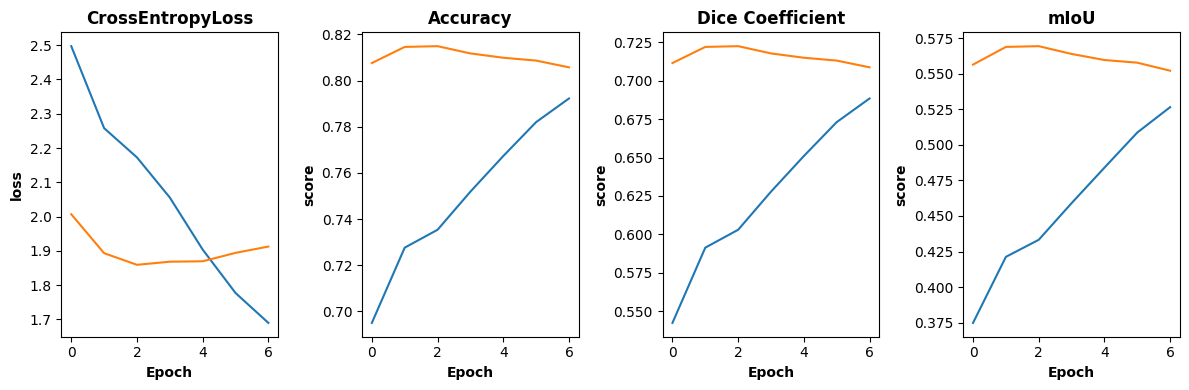

In [140]:
loss_and_metric_plot(RESULTS)

# **7. Final Predictions**

In [141]:
def old_predictions_mask(test_dataloader:torch.utils.data.DataLoader):
    
    checkpoint = torch.load("./best_model.pth")

    loaded_model = smp.Unet(encoder_name="resnet50",encoder_weights = None, classes = NUM_CLASSES)

    loaded_model.segmentation_head = nn.Sequential(
    loaded_model.segmentation_head,
    nn.Dropout2d(p=0.5)
    )
    loaded_model.load_state_dict(checkpoint)

    loaded_model.to(device = DEVICE)

    loaded_model.eval()

    y_pred_mask = []

    with torch.inference_mode():
        for batch,X in tqdm(enumerate(test_dataloader), total = len(test_dataloader)):
            X = X.to(device = DEVICE, dtype = torch.float32)
            mask_logit = loaded_model(X)
            mask_prob = mask_logit.softmax(dim = 1)
            mask_pred = mask_prob.argmax(dim = 1)
            y_pred_mask.append(mask_pred.detach().cpu())

    y_pred_mask = torch.cat(y_pred_mask)
    
    return y_pred_mask

In [142]:
def predictions_mask(test_dataloader: torch.utils.data.DataLoader):
    """
    Generate predictions for the test dataset and return predictions along with ground truth masks.

    Parameters:
    - test_dataloader: DataLoader for the test dataset.

    Returns:
    - y_pred_mask: Tensor containing predicted masks.
    - y_true_mask: Tensor containing ground truth masks.
    """
    checkpoint = torch.load("./best_model.pth")

    # Load the model
    loaded_model = smp.DeepLabV3Plus(encoder_name="resnet50", encoder_weights=None, classes=NUM_CLASSES)
    loaded_model.segmentation_head = nn.Sequential(
        loaded_model.segmentation_head,
        nn.Dropout2d(p=0.5)
    )
    loaded_model.load_state_dict(checkpoint)
    loaded_model.to(device=DEVICE)
    loaded_model.eval()

    y_pred_mask = []
    y_true_mask = []

    with torch.inference_mode():
        for batch, (X, y) in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
            X = X.to(device=DEVICE, dtype=torch.float32)  # Send images to device
            y_true_mask.append(y)  # Append ground truth masks

            # Generate predictions
            mask_logit = loaded_model(X)
            mask_prob = mask_logit.softmax(dim=1)
            mask_pred = mask_prob.argmax(dim=1)
            y_pred_mask.append(mask_pred.detach().cpu())

    # Concatenate predictions and ground truth masks
    y_pred_mask = torch.cat(y_pred_mask)
    y_true_mask = torch.cat(y_true_mask)

    return y_pred_mask, y_true_mask


**We are going to perform all the previous steps that we do to transform our data and get it ready to enter into the model.**

In [143]:
# image_path_test = "/home/training/NCU/DL/FinalProject/OriginalDataset/BCSS/test"
image_path_test = "/home/training/NCU/DL/FinalProject/PreprocessedNoisyDataset/BCSS/val"
mask_path_test = "/home/training/NCU/DL/FinalProject/OriginalDataset/BCSS/val_mask"

IMAGE_PATH_LIST_TEST = list(Path(image_path_test).glob("*.png"))
# Match corresponding mask paths
MASK_PATH_LIST_TEST = [
    Path(mask_path_test) / f"{image_path.stem}.png"
    for image_path in IMAGE_PATH_LIST_TEST
]

print(f'Total Images Train: {len(IMAGE_PATH_LIST_TEST)}')
print(f"Total Masks Test: {len(MASK_PATH_LIST_TEST)}")

Total Images Train: 5429
Total Masks Test: 5429


In [144]:
#data_test = pd.DataFrame({'Image':IMAGE_PATH_LIST_TEST})
data_test = pd.DataFrame({'Image': IMAGE_PATH_LIST_TEST, 'Mask': MASK_PATH_LIST_TEST})
data_test.head()

Image  \
0  /home/training/NCU/DL/FinalProject/Preprocesse...   
1  /home/training/NCU/DL/FinalProject/Preprocesse...   
2  /home/training/NCU/DL/FinalProject/Preprocesse...   
3  /home/training/NCU/DL/FinalProject/Preprocesse...   
4  /home/training/NCU/DL/FinalProject/Preprocesse...   

                                                Mask  
0  /home/training/NCU/DL/FinalProject/OriginalDat...  
1  /home/training/NCU/DL/FinalProject/OriginalDat...  
2  /home/training/NCU/DL/FinalProject/OriginalDat...  
3  /home/training/NCU/DL/FinalProject/OriginalDat...  
4  /home/training/NCU/DL/FinalProject/OriginalDat...

- **Dataset**

In [145]:
class OldCustomTestDataset(Dataset):
    def __init__(self, data:pd.DataFrame, image_transforms):
        self.data = data
        self.image_transforms = image_transforms
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image_path = self.data.iloc[idx, 0]
        image = Image.open(image_path).convert("RGB")
        image = self.image_transforms(image)
        
        return image

In [146]:
class Old2CustomTestDataset(Dataset):
    def __init__(self, data: pd.DataFrame, image_transforms, mask_transforms):
        self.data = data
        self.image_transforms = image_transforms
        self.mask_transforms = mask_transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data.iloc[idx, 0]
        image = Image.open(image_path).convert("RGB")
        image = self.image_transforms(image)
        
        mask_path = self.data.iloc[idx, 1]
        mask = Image.open(mask_path)
        mask = self.mask_transforms(mask)
        
        return image, mask

In [147]:
class CustomTestDataset(Dataset):
    def __init__(self, data: pd.DataFrame, image_transforms, mask_transforms):
        """
        Custom dataset for test images and masks.

        Parameters:
        - data (pd.DataFrame): DataFrame containing image and mask paths.
        - image_transforms: Transformations to apply to the images.
        - mask_transforms: Transformations to apply to the masks.
        """
        self.data = data
        self.image_transforms = image_transforms
        self.mask_transforms = mask_transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Load the image
        image_path = self.data.iloc[idx, 0]
        image = Image.open(image_path).convert("RGB")
        image = self.image_transforms(image)

        # Load the corresponding ground truth mask
        mask_path = self.data.iloc[idx, 1]
        mask = Image.open(mask_path)
        mask = self.mask_transforms(mask)

        return image, mask


In [148]:
# Dataset
# test_dataset = CustomTestDataset(data_test, image_transforms)
test_dataset = CustomTestDataset(data_test, image_transforms, mask_transforms)

# DataLoader
test_dataloader = DataLoader(dataset = test_dataset, batch_size = BATCH_SIZE, shuffle = False)

In [149]:
# We execute the predictions!!
# y_pred_mask = predictions_mask(test_dataloader)

# Get predictions and ground truth masks
y_pred_mask, y_true_mask = predictions_mask(test_dataloader)

100%|██████████| 85/85 [00:15<00:00,  5.49it/s]


**We visualize the first 10 images of our test set and the predicted mask.**

In [150]:
import cv2
import matplotlib.pyplot as plt

def visualize_predictions_with_ground_truth(image_paths, pred_masks, true_masks):
    """
    Visualize test images, predicted masks, and ground truth masks.

    Parameters:
    - image_paths: List of paths to test images.
    - pred_masks: Tensor of predicted masks.
    - true_masks: Tensor of ground truth masks.
    """
    fig, ax = plt.subplots(nrows=10, ncols=3, figsize=(15, 35))  # 3 columns: Image, Predicted Mask, Ground Truth Mask
    
    for index, (image_path, pred_mask, true_mask) in enumerate(zip(image_paths, pred_masks, true_masks)):
        if index >= 10:
            break  # Show only the first 10 examples
        
        # Load and display the image
        img_bgr = cv2.imread(str(image_path))
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        ax[index, 0].imshow(img_rgb)
        ax[index, 0].axis('off')
        ax[index, 0].set_title("Image", fontsize=12, fontweight="bold", color="black")
        
        # Display the predicted mask
        ax[index, 1].imshow(pred_mask.squeeze().numpy(), cmap="viridis")
        ax[index, 1].axis('off')
        ax[index, 1].set_title("Predicted Mask", fontsize=12, fontweight="bold", color="black")
        
        # Display the ground truth mask
        ax[index, 2].imshow(true_mask.squeeze().numpy(), cmap="viridis")
        ax[index, 2].axis('off')
        ax[index, 2].set_title("Ground Truth Mask", fontsize=12, fontweight="bold", color="black")
    
    fig.tight_layout()
    plt.show()


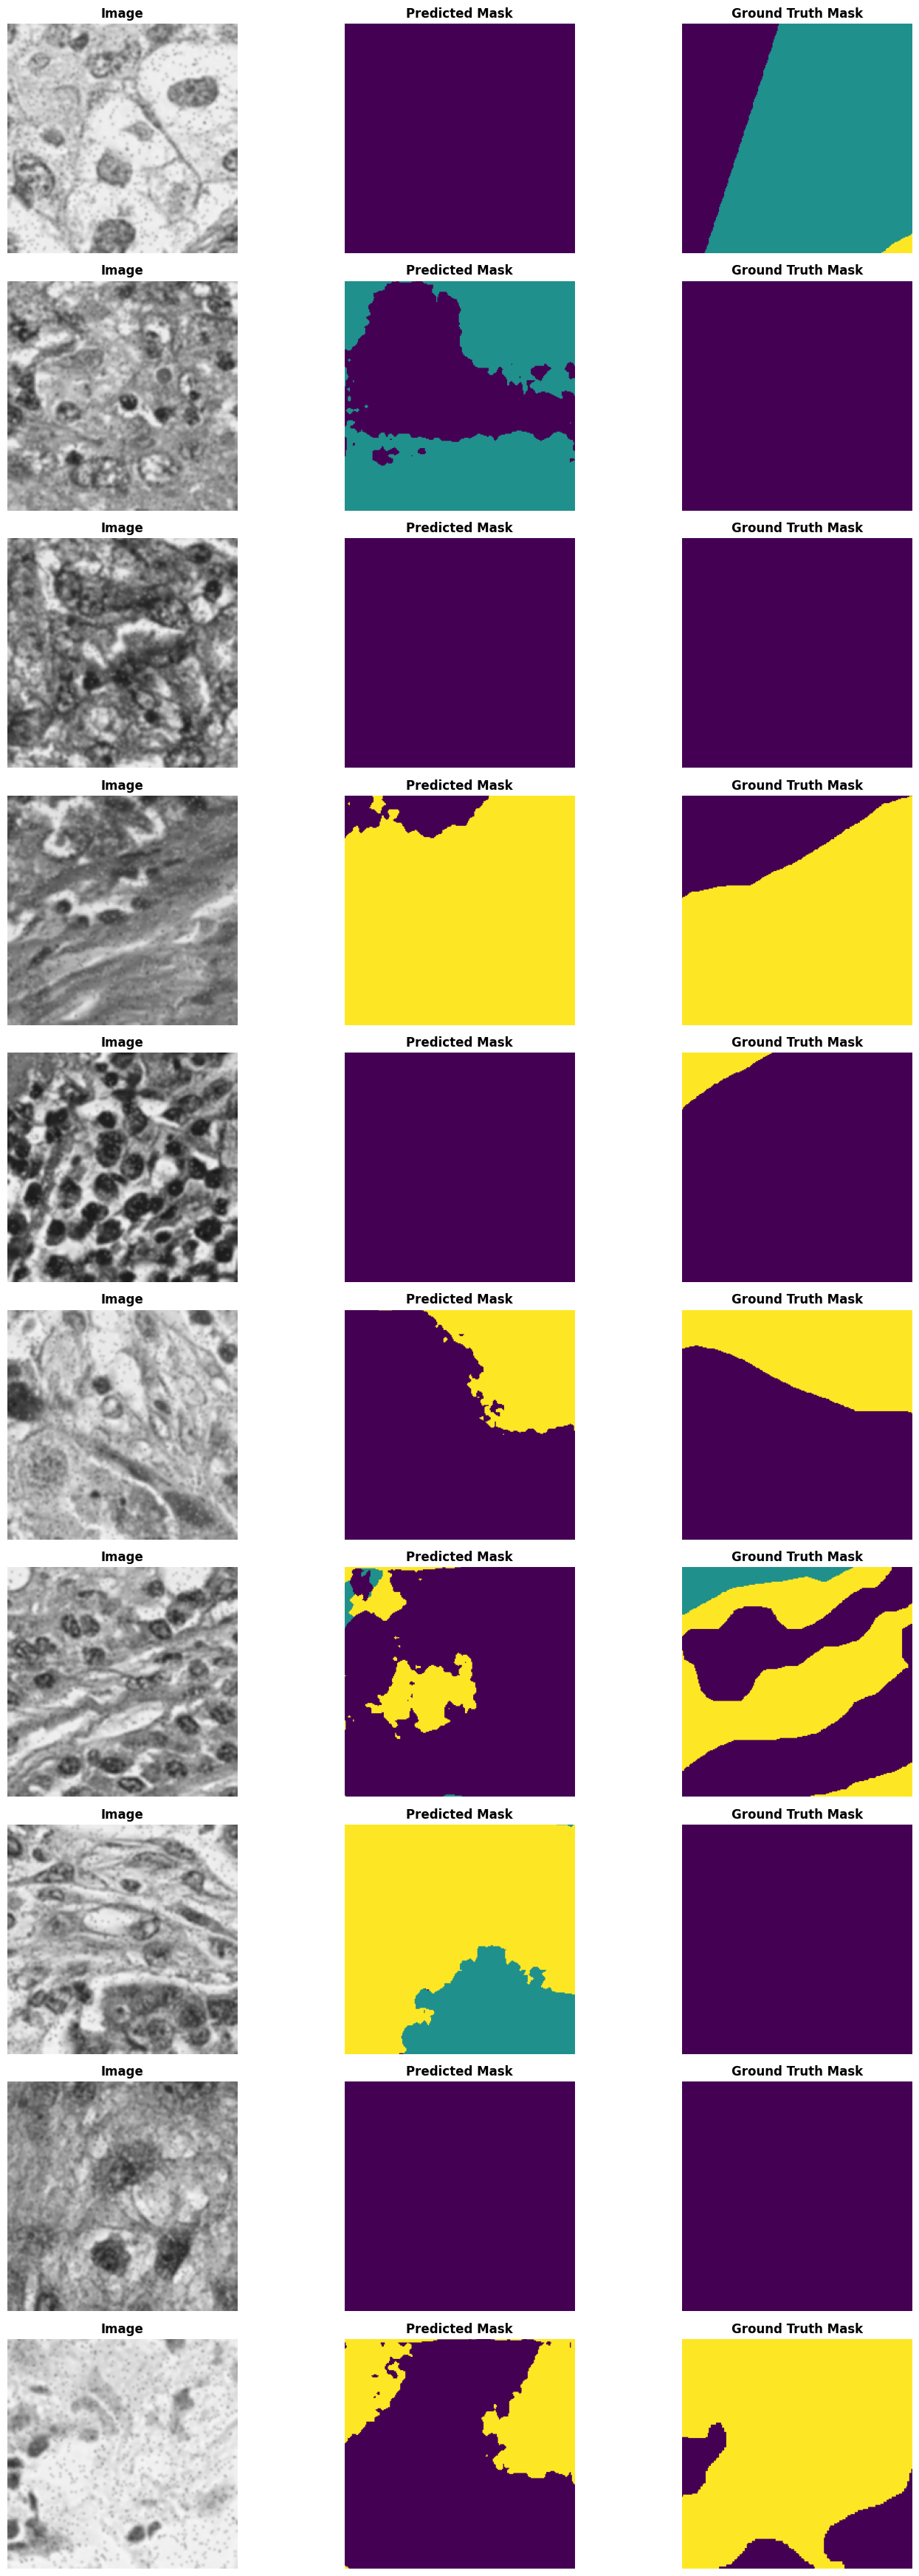

In [151]:
# Visualize predictions and ground truth masks
visualize_predictions_with_ground_truth(IMAGE_PATH_LIST_TEST, y_pred_mask, y_true_mask)

In [152]:
import segmentation_models_pytorch as smp
import torch

def final_test(model, dataloader, device, num_classes):
    model.eval()  # Set the model to evaluation mode

    val_accuracy = 0.0
    val_miou = 0.0
    val_dice = 0.0

    # Initialize per-class metrics storage
    per_class_iou = torch.zeros(num_classes)
    class_count = torch.zeros(num_classes)

    with torch.inference_mode():  # Disable gradient computation
        for X, y in dataloader:
            X = X.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.long)

            # Forward pass
            logit_mask = model(X)
            pred_mask = logit_mask.softmax(dim=1).argmax(dim=1)

            # Get stats for mIoU and Dice
            tp, fp, fn, tn = smp.metrics.get_stats(
                output=pred_mask.detach().cpu().long(),
                target=y.squeeze().cpu().long(),
                mode="multiclass",
                num_classes=num_classes
            )

            # Accumulate overall metrics
            val_accuracy += smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro").numpy()
            val_miou += smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro").numpy()
            val_dice += smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro").numpy()

            # Compute batch-averaged per-class IoU and accumulate
            class_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="none")  # Shape [num_classes]
            per_class_iou += class_iou.mean(dim=0)  # Average IoU per class over the batch
            class_count += 1

    # Final metrics
    val_accuracy /= len(dataloader)
    val_miou /= len(dataloader)
    val_dice /= len(dataloader)
    per_class_iou /= class_count  # Average per-class IoU over all batches

    # Print the metrics
    print(f"Final Test Results:")
    print(f"Overall Accuracy: {val_accuracy:.4f}")
    print(f"Overall Dice Coefficient: {val_dice:.4f}")
    print(f"Overall mIoU: {val_miou:.4f}\n")

    print("Per-Class IoU:")
    for cls in range(num_classes):
        print(f"Class {cls}: {per_class_iou[cls]:.4f}")


In [153]:
# Load the trained model
checkpoint_path = "./best_model.pth"
model = smp.DeepLabV3Plus(encoder_name="resnet50",encoder_weights = None, classes = NUM_CLASSES)

model.segmentation_head = nn.Sequential(
    model.segmentation_head,
    nn.Dropout2d(p=0.5)
    )

model.load_state_dict(torch.load(checkpoint_path))
model.to(DEVICE)

# Run final test
final_test(model, val_dataloader, device=DEVICE, num_classes=NUM_CLASSES)

Final Test Results:
Overall Accuracy: 0.8149
Overall Dice Coefficient: 0.7224
Overall mIoU: 0.5694

Per-Class IoU:
Class 0: 0.5031
Class 1: 0.6189
Class 2: 0.4362
